In [1]:
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.data import *
from jetstream_hugo.anyspell import *
from jetstream_hugo.jet_finding import *
from jetstream_hugo.clustering import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
exp = JetFindingExperiment(DataHandler(f"{DATADIR}/ERA5/plev/high_wind/6H/results/1"))
ds = exp.ds
all_jets_one_df, all_jets_over_time, flags = exp.track_jets()
props_as_df_uncat = exp.props_as_df(False)
props_as_df = exp.props_as_df(True)
all_props_over_time = exp.props_over_time(all_jets_over_time, props_as_df_uncat)
ds = exp.ds
da = exp.ds["s"]
jet_pos_da = exp.jet_position_as_da()
props_as_df = get_double_jet_index(props_as_df, jet_pos_da)

In [ ]:
def extract_dynamical_seasons(labels: pl.DataFrame, len_spring: int = 20):    
    summer_cluster = labels.filter(pl.col("time").dt.month() == 7)["labels"].mode().item()
    seasons = labels.group_by(
        pl.col("time").dt.year().alias("year")
    ).agg(
        pl.col("time").get((pl.col("labels") == summer_cluster).arg_true().first()).alias("start"),
        pl.col("time").get((pl.col("labels") == summer_cluster).arg_true().last()).alias("end")
    ).with_columns(
        spring=pl.datetime_ranges(pl.col("start") - datetime.timedelta(days=len_spring), pl.col("start"), "6h"),
        summer=pl.datetime_ranges(pl.col("start"), pl.col("end"), "6h"),
        autumn=pl.datetime_ranges(pl.col("end"), pl.col("end") + datetime.timedelta(days=len_spring), "6h"),
    ).drop("year", "start", "end")
    return [seasons[season].explode().sort() for season in seasons.columns]

In [11]:
dh = DataHandler(f"{DATADIR}/ERA5/plev/high_wind/6H/results/3")
exp_wind = Experiment(dh)
centers_kmeans, labels_kmeans = exp_wind.do_kmeans(7, 200)
spring, summer, autumn = extract_dynamical_seasons(xarray_to_polars(labels_kmeans), 20)
summer_daily = summer.filter(summer.dt.hour() == 0)
da_summer = dh.da.sel(time=summer.to_numpy())
dh_summer = DataHandler.from_basepath_and_da(exp_wind.path.parent, da_summer, save_da=True)
exp_summer = Experiment(dh_summer)
nx, ny, n_pca = 4, 4, 200
net, centers, labels = exp_summer.som_cluster(
    nx,
    ny,
    n_pca,
    sigma=1.5,
    sigmaN=1e-5,
    train_kwargs=dict(num_epochs=20),
    init="pca",
)
populations = net.compute_populations()
coords = net.neighborhoods.coordinates

ds_center_path = exp_summer.path.joinpath(f"uvs_som_{nx}_{ny}_{n_pca}_pbc_center.nc")
if not ds_center_path.is_file():
    ds = exp.ds
    ds_center_summer = labels_to_centers(labels, ds)
    ds_center_summer.to_netcdf(ds_center_path)
else:
    ds_center_summer = xr.open_dataset(ds_center_path)
mask = labels_to_mask(labels)
mask_da = xr.DataArray(mask, coords={"time": exp_summer.da.time, "cluster": np.arange(net.n_nodes)})

all_jets_center_summer = find_all_jets(xarray_to_polars(ds_center_summer), base_s_thresh=22, alignment_thresh=0.5)
all_jets_center_summer = is_polar_gmix(all_jets_center_summer, ("lon", "lat", "lev"), n_components=2, n_init=100, mode="year")

100%|██████████| 16/16 [00:00<00:00, 429.98it/s]


In [15]:
from sklearn.metrics import pairwise_distances
dists = pairwise_distances(net.weights)
sigma = np.quantile(dists[dists > 0].flatten(), 0.05)
spells = get_persistent_spell_times_from_som(labels, dists, sigma, 32, nt_before=20, nojune=True, daily=True)

labels_daily = labels.sel(time=labels.time.dt.hour == 0)
mask_daily = labels_to_mask(labels_daily)
spells_per_cluster = spells.filter(pl.col("relative_index") == 0).group_by("value").len()
spells_per_cluster = pl.Series("value", np.arange(net.n_nodes)).to_frame().join(spells_per_cluster, how="left", on="value").fill_null(0)
numbering = [f"{numb + 1}, {spells_per_cluster[int(numb), 'len']}" for numb in range(net.n_nodes)]

props_as_df_anoms = compute_anomalies_pl(props_as_df, ("jet", ), 31, True)
props_masked = mask_from_spells_pl(spells, props_as_df_anoms)
props_masked_ = props_masked.group_by(pl.col("value"), pl.col("relative_index"), pl.col("jet")).mean().rename({"value": "cluster"})
indexer = pl.Series("cluster", np.arange(net.n_nodes)).to_frame().join(props_masked[:, ["jet", "relative_index"]].unique(("jet", "relative_index")), how="cross").sort("cluster", "jet", "relative_index")
props_masked_ = indexer.join(props_masked_, how="left", on=["cluster", "jet", "relative_index"])

# natural coordinate composites

In [ ]:
da_T = open_da(
    "ERA5", "surf", "t2m", "dailymean", "all", None, -100, 60, 0, 90, "all",
)
da_T = compute(da_T)
da_tp = open_da(
    "ERA5", "surf", "tp", "dailysum", "all", None, -100, 60, 0, 90, "all",
)
da_tp = compute(da_tp)

da_apvs = DataHandler.from_specs("ERA5", "thetalev", "apvs", "dailymean", "all", None, None, None, None, None, 350).da
da_apvs = extract(da_apvs, "all", None,  -100, 60, 0, 90)
da_apvs = compute(da_apvs)
da_cpvs = DataHandler.from_specs("ERA5", "thetalev", "cpvs", "dailymean", "all", None, None, None, None, None, 350).da
da_cpvs = extract(da_cpvs, "all", None,  -100, 60, 0, 90)
da_cpvs = compute(da_cpvs)

KeyboardInterrupt: 

# real space composites

In [ ]:
da_tp = open_da(
    "ERA5", "surf", "tp", "dailysum", "all", None, None, None, None, None, "all", 'dayofyear', {'dayofyear': ('win', 15)}, None,
)
da_tp = da_tp.sel(time=summer_daily.to_numpy())
da_T = open_da(
    "ERA5", "surf", "t2m", "dailymean", "all", None, None, None, None, None, "all", 'dayofyear', {'dayofyear': ('win', 15)}, None,
)
da_T = da_T.sel(time=summer_daily.to_numpy())
da_apvs = DataHandler.from_specs("ERA5", "thetalev", "apvs", "dailymean", "all", None, *get_region(ds), 350).da
da_apvs = da_apvs.sel(time=summer_daily.to_numpy())
da_cpvs = DataHandler.from_specs("ERA5", "thetalev", "cpvs", "dailymean", "all", None, *get_region(ds), 350).da
da_cpvs = da_cpvs.sel(time=summer_daily.to_numpy())
da_z = open_da(
    "ERA5", "plev", "z", "dailymean", "all", None, None, None, None, None, 500, 'dayofyear', {'dayofyear': ('win', 15)}, None,
)
da_z = da_z.sel(time=summer_daily.to_numpy())

## masked jets

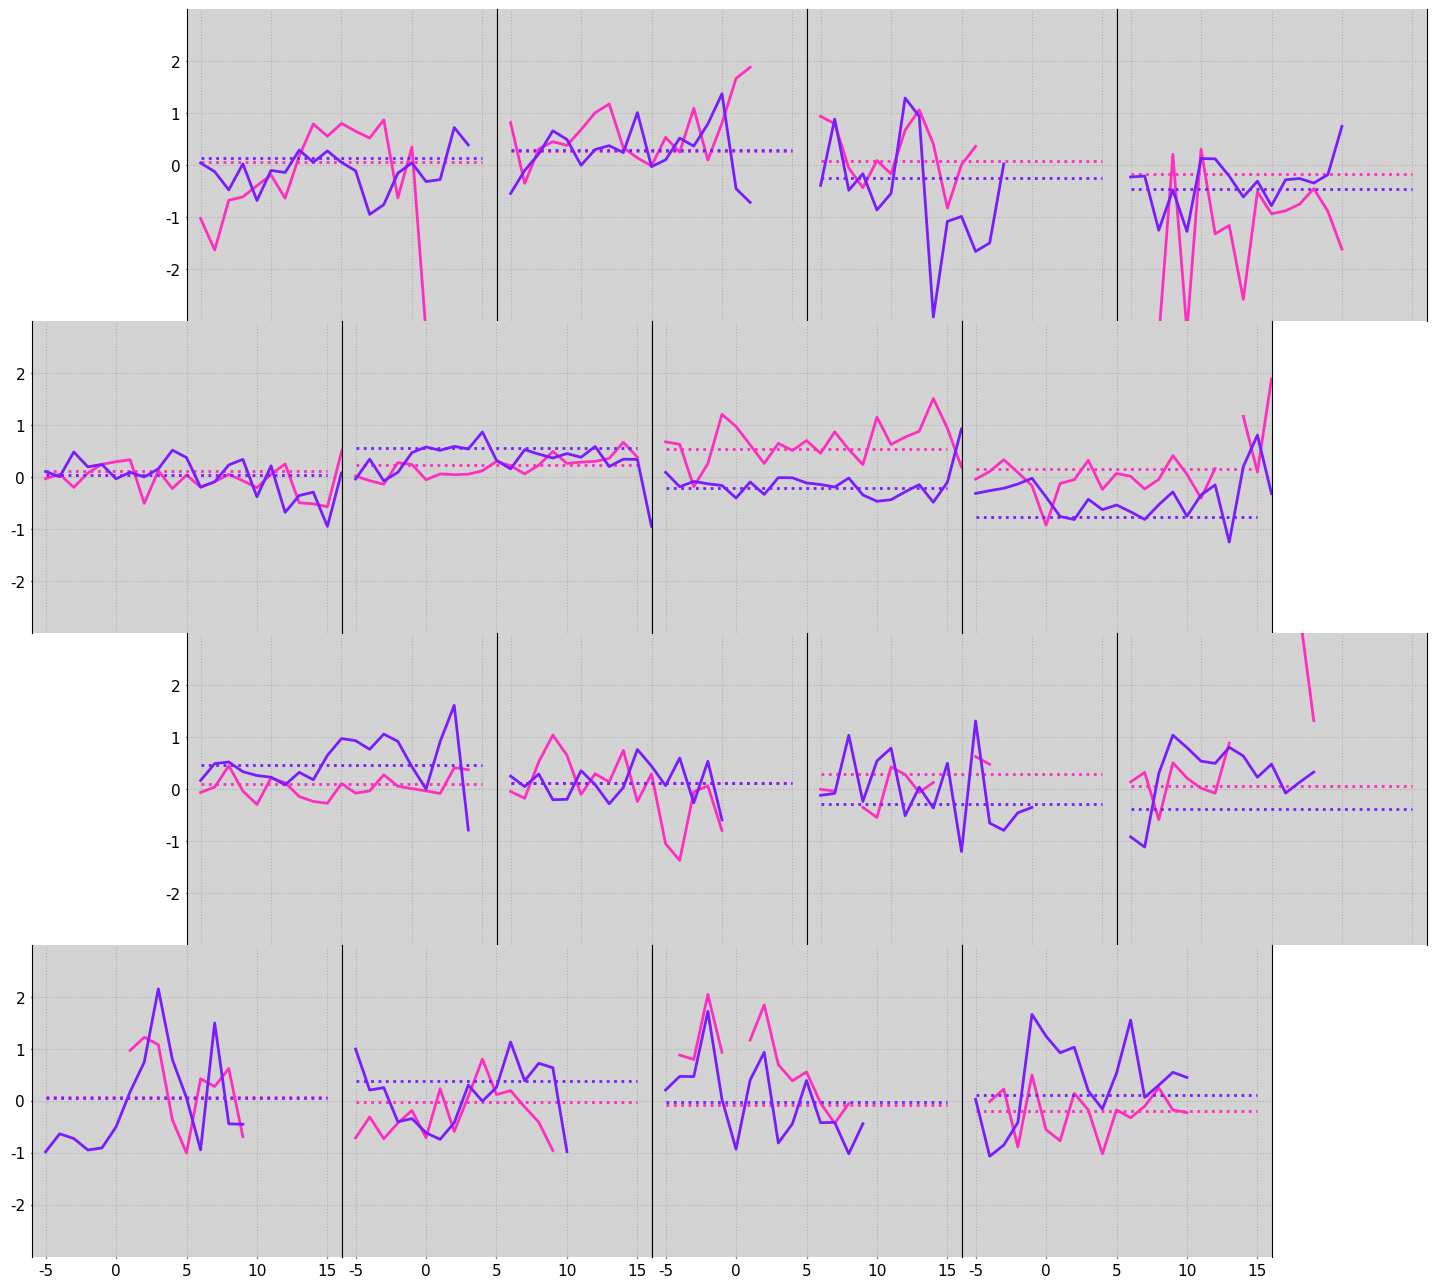

In [14]:
fig, axes = honeycomb_panel(
    4, 4, .9
)
rel_ind_ticks = [-5, 0, 5, 10, 15]
anom_ticks = [-2, -1, 0, 1, 2]
varname = "mean_lat"
mean_anoms = {}
for jet in ["STJ", "EDJ"]:
    to_plot = props_as_df_anoms.filter(pl.col("time").cast(pl.Datetime("us")).is_in(labels["time"].values.astype('datetime64[ms]').tolist()), pl.col("jet") == jet)[varname].to_numpy()
    mean_anoms[jet] = timeseries_on_map(to_plot, net.latest_bmus)[0]
for (l, ax), (i, j) in zip(enumerate(axes.ravel()), zip(*np.unravel_index(np.arange(axes.size), axes.shape))):
    ax.spines[["top", "bottom"]].set_visible(False)
    for k, jet in enumerate(["STJ", "EDJ"]):
        to_plot_ = props_masked_.filter(pl.col("jet") == jet, pl.col("cluster") == l)
        ax.plot(to_plot_["relative_index"], to_plot_[varname], color=COLORS[2 - k], lw=2)
        ax.plot([rel_ind_ticks[0], rel_ind_ticks[-1]], [mean_anoms[jet][l], mean_anoms[jet][l]], color=COLORS[2 - k], lw=2, linestyle="dotted")
    ax.grid(linestyle="dotted")
    ax.set_xlim([-6, 16])
    ax.set_ylim([-3, 3])
    ax.set_facecolor('lightgray')
    if i == 3:
        ax.set_xticks(rel_ind_ticks, labels=rel_ind_ticks)
        ax.tick_params(axis='x', width=1, size=1)
    else:
        ax.set_xticks(rel_ind_ticks, labels=[])
        ax.tick_params(axis='x', width=0, size=0)
    if j == 0:
        ax.set_yticks(anom_ticks, labels=anom_ticks)
        ax.tick_params(axis='y', width=1, size=1)
    else:       
        ax.set_yticks(anom_ticks, labels=[])
        ax.tick_params(axis='y', width=0, size=0)

In [8]:
ds_ = ds.sel(time=summer_daily.to_numpy())
ds_ = compute(ds_, progress_flag=True)

In [9]:
uvs_masked = mask_from_spells_pl(spells, ds_)

In [12]:
uvs_masked_per_cluster = uvs_masked.groupby("value").mean("spell").rename({"value": "cluster"})
u_clu = uvs_masked_per_cluster.cluster.values.astype(np.int32)
to_zero = np.arange(net.n_nodes)[~np.isin(np.arange(net.n_nodes), u_clu)]
indexer = np.repeat(u_clu, np.diff(np.append(u_clu, [net.n_nodes])))
uvs_masked_per_cluster = uvs_masked_per_cluster.sel(cluster=indexer)
uvs_masked_per_cluster = uvs_masked_per_cluster.assign_coords(cluster=np.arange(net.n_nodes))
uvs_masked_per_cluster.loc[{"cluster": to_zero}] = 0.
jets_masked = find_all_jets(xarray_to_polars(uvs_masked_per_cluster), base_s_thresh=30)

## temp

In [14]:
da_T = compute(da_T, progress_flag=True)

In [18]:
da_T_europe = extract(da_T, "all", None, -15, 40, 30, 75)
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(da_T_europe), numbering=True)
_ = clu.add_any_contour_from_mask(da_T_europe, mask_daily, cmap=colormaps.balance, levels=12, q=1-1e-3)
axes = clu.axes.ravel()
for i in range(net.n_nodes):
    jets = all_jets_center.filter(pl.col("cluster") == i)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la, is_p = jet[["lon", "lat", "is_polar"]].to_numpy().T
        axes[i].scatter(lo, la, c=is_p, lw=1, s=10, cmap=PINKPURPLE, vmin=0, vmax=1)

In [19]:
T_masked = mask_from_spells_pl(spells, da_T)

In [20]:
T_masked_per_cluster = T_masked.groupby("value").mean("spell").rename({"value": "cluster"})
u_clu = T_masked_per_cluster.cluster.values.astype(np.int32)
to_zero = np.arange(net.n_nodes)[~np.isin(np.arange(net.n_nodes), u_clu)]
indexer = np.repeat(u_clu, np.diff(np.append(u_clu, [net.n_nodes])))
T_masked_per_cluster = T_masked_per_cluster.sel(cluster=indexer)
T_masked_per_cluster[to_zero, ...] = 0.
T_masked_per_cluster = T_masked_per_cluster.assign_coords(cluster=np.arange(net.n_nodes))

In [28]:
T_masked_per_cluster_europe = extract(T_masked_per_cluster, "all", None, -15, 40, 30, 75)

clu = Clusterplot(4, 4, honeycomb=True, region=get_region(T_masked_per_cluster_europe), numbering=numbering)
_ = clu.add_contourf(T_masked_per_cluster_europe.sel(relative_index=0), cmap=colormaps.balance, levels=13, q=1-1e-2)
axes = clu.axes.ravel()
for i in range(net.n_nodes):
    jets = jets_masked.filter(pl.col("cluster") == i, pl.col("relative_index") == 0)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la = jet[["lon", "lat"]].to_numpy().T
        axes[i].scatter(lo, la, lw=1, s=10, c="black")
for i in range(net.n_nodes):
    jets = all_jets_center.filter(pl.col("cluster") == i)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la, is_p = jet[["lon", "lat", "is_polar"]].to_numpy().T
        axes[i].scatter(lo, la, color="gray", lw=1, s=10)

## precip

In [29]:
da_tp = compute(extract(da_tp, "all", None, *get_region(ds)), progress_flag=True)

In [33]:
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(da_tp), numbering=True)
_ = clu.add_any_contour_from_mask(da_tp * 1000, mask_daily, cmap=colormaps.precip4_diff_19lev, levels=12, q=1-1e-3)
axes = clu.axes.ravel()
for i in range(net.n_nodes):
    jets = all_jets_center.filter(pl.col("cluster") == i)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la, is_p = jet[["lon", "lat", "is_polar"]].to_numpy().T
        axes[i].scatter(lo, la, c=is_p, lw=1, s=10, cmap=PINKPURPLE, vmin=0, vmax=1)

In [34]:
tp_masked = mask_from_spells_pl(spells, da_tp)

In [35]:
tp_masked_per_cluster = tp_masked.groupby("value").mean("spell").rename({"value": "cluster"})
u_clu = tp_masked_per_cluster.cluster.values.astype(np.int32)
to_zero = np.arange(net.n_nodes)[~np.isin(np.arange(net.n_nodes), u_clu)]
indexer = np.repeat(u_clu, np.diff(np.append(u_clu, [net.n_nodes])))
tp_masked_per_cluster = tp_masked_per_cluster.sel(cluster=indexer)
tp_masked_per_cluster[to_zero, ...] = 0.
tp_masked_per_cluster = tp_masked_per_cluster.assign_coords(cluster=np.arange(net.n_nodes))

In [40]:
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(tp_masked_per_cluster), numbering=numbering)
_ = clu.add_contourf(tp_masked_per_cluster.sel(relative_index=0), cmap=colormaps.precip4_diff_19lev, levels=13, q=1-1e-2)

In [43]:
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(tp_masked_per_cluster), numbering=numbering)
_ = clu.add_contourf(tp_masked_per_cluster.sel(relative_index=0), cmap=colormaps.precip4_diff_19lev, levels=13, q=1-1e-2)
axes = clu.axes.ravel()
for i in range(net.n_nodes):
    jets = jets_masked.filter(pl.col("cluster") == i, pl.col("relative_index") == 0)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la = jet[["lon", "lat"]].to_numpy().T
        axes[i].plot(lo, la, lw=3, c="black")
for i in range(net.n_nodes):
    jets = all_jets_center.filter(pl.col("cluster") == i)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la = jet[["lon", "lat"]].to_numpy().T
        axes[i].plot(lo, la, color="gray", lw=3)

## aPVS

In [48]:
da_apvs = compute(da_apvs, progress_flag=True)

In [60]:
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(da_apvs), numbering=True)
_ = clu.add_any_contour_from_mask(da_apvs, mask_daily, cmap=colormaps.voltage_r, levels=7, q=1-1e-3)
axes = clu.axes.ravel()
for i in range(net.n_nodes):
    jets = all_jets_center.filter(pl.col("cluster") == i)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la, is_p = jet[["lon", "lat", "is_polar"]].to_numpy().T
        axes[i].scatter(lo, la, c=is_p, lw=1, s=10, cmap=PINKPURPLE, vmin=0, vmax=1)

In [55]:
apvs_masked = mask_from_spells_pl(spells, da_apvs)

In [56]:
apvs_masked_per_cluster = apvs_masked.groupby("value").mean("spell").rename({"value": "cluster"})
u_clu = apvs_masked_per_cluster.cluster.values.astype(np.int32)
to_zero = np.arange(net.n_nodes)[~np.isin(np.arange(net.n_nodes), u_clu)]
indexer = np.repeat(u_clu, np.diff(np.append(u_clu, [net.n_nodes])))
apvs_masked_per_cluster = apvs_masked_per_cluster.sel(cluster=indexer)
apvs_masked_per_cluster[to_zero, ...] = 0.
apvs_masked_per_cluster = apvs_masked_per_cluster.assign_coords(cluster=np.arange(net.n_nodes))

In [61]:
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(apvs_masked_per_cluster), numbering=numbering)
_ = clu.add_contourf(apvs_masked_per_cluster.sel(relative_index=0), cmap=colormaps.voltage_r, levels=7, q=1-1e-2)

In [62]:
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(apvs_masked_per_cluster), numbering=numbering)
_ = clu.add_contourf(apvs_masked_per_cluster.sel(relative_index=0), cmap=colormaps.voltage_r, levels=7, q=1-1e-2)
axes = clu.axes.ravel()
for i in range(net.n_nodes):
    jets = jets_masked.filter(pl.col("cluster") == i, pl.col("relative_index") == 0)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la = jet[["lon", "lat"]].to_numpy().T
        axes[i].plot(lo, la, lw=3, c="black")
for i in range(net.n_nodes):
    jets = all_jets_center.filter(pl.col("cluster") == i)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la = jet[["lon", "lat"]].to_numpy().T
        axes[i].plot(lo, la, color="gray", lw=3)

## cPVS

In [63]:
da_cpvs = compute(da_cpvs, progress_flag=True)

In [64]:
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(da_cpvs), numbering=True)
_ = clu.add_any_contour_from_mask(da_cpvs, mask_daily, cmap=colormaps.flamingo_r, levels=7, q=1-1e-3)
axes = clu.axes.ravel()
for i in range(net.n_nodes):
    jets = all_jets_center.filter(pl.col("cluster") == i)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la, is_p = jet[["lon", "lat", "is_polar"]].to_numpy().T
        axes[i].scatter(lo, la, c=is_p, lw=1, s=10, cmap=PINKPURPLE, vmin=0, vmax=1)

In [65]:
cpvs_masked = mask_from_spells_pl(spells, da_cpvs)

In [66]:
cpvs_masked_per_cluster = cpvs_masked.groupby("value").mean("spell").rename({"value": "cluster"})
u_clu = cpvs_masked_per_cluster.cluster.values.astype(np.int32)
to_zero = np.arange(net.n_nodes)[~np.isin(np.arange(net.n_nodes), u_clu)]
indexer = np.repeat(u_clu, np.diff(np.append(u_clu, [net.n_nodes])))
cpvs_masked_per_cluster = cpvs_masked_per_cluster.sel(cluster=indexer)
cpvs_masked_per_cluster[to_zero, ...] = 0.
cpvs_masked_per_cluster = cpvs_masked_per_cluster.assign_coords(cluster=np.arange(net.n_nodes))

In [67]:
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(cpvs_masked_per_cluster), numbering=numbering)
_ = clu.add_contourf(cpvs_masked_per_cluster.sel(relative_index=0), cmap=colormaps.flamingo_r, levels=7, q=1-1e-2)

In [68]:
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(cpvs_masked_per_cluster), numbering=numbering)
_ = clu.add_contourf(cpvs_masked_per_cluster.sel(relative_index=0), cmap=colormaps.flamingo_r, levels=7, q=1-1e-2)
axes = clu.axes.ravel()
for i in range(net.n_nodes):
    jets = jets_masked.filter(pl.col("cluster") == i, pl.col("relative_index") == 0)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la = jet[["lon", "lat"]].to_numpy().T
        axes[i].plot(lo, la, lw=3, c="black")
for i in range(net.n_nodes):
    jets = all_jets_center.filter(pl.col("cluster") == i)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la = jet[["lon", "lat"]].to_numpy().T
        axes[i].plot(lo, la, color="gray", lw=3)